In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

import os

import pickle


from helpers.evaluation import run_BDTs
from helpers.physics_functions import *

In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [3]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

project_id = "dimu_supp"
particle_type = "upsilon"

flow_training_id = f"lowmass_{particle_type}_nojet_{project_id}"
flow_training_dir = os.path.join("models", f"{flow_training_id}/")

with open(f"models/{flow_training_id}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"processed_data/lowmass_{particle_type}_nojet_test_band_data", "rb") as infile: 
    test_dict = pickle.load(infile)
    
with open(f"processed_data/lowmass_{particle_type}_nojet_samesign_band_data", "rb") as infile: 
    samesign_dict = pickle.load(infile)
    
    
with open(f"models/{flow_training_id}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    print(configs)
    


feature_set = ['dimu_pt', 'dimu_eta', 'mumu_deltaR', 'mumu_deltapT', 'dimu_mass']



In [4]:
# Assemble the test set -- consists of both SB and SR

feature_set = ['dimu_pt', 'dimu_eta', 'mumu_deltaR', 'mumu_deltapT', 'dimu_mass']


num_events_test_SR = test_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_test_SB = test_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+test_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_samesign = samesign_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]

test_events_SB = np.empty((num_events_test_SB, len(feature_set)))
test_events_SR = np.empty((num_events_test_SR, len(feature_set)))
test_events_samesign = np.empty((num_events_samesign, len(feature_set)))


for i, feat in enumerate(feature_set):
    
    test_events_SR[:,i] = test_dict["SR"]["s_inj_data"][feat].reshape(-1,)
    loc_arr = np.concatenate((test_dict["SBL"]["s_inj_data"][feat], test_dict["SBH"]["s_inj_data"][feat]))
    test_events_SB[:,i] = loc_arr.reshape(-1,)
    #samesign
    loc_arr = np.concatenate((samesign_dict["SR"]["s_inj_data"][feat], samesign_dict["SBL"]["s_inj_data"][feat], samesign_dict["SBH"]["s_inj_data"][feat]))
    test_events_samesign[:,i] = loc_arr.reshape(-1,)


print(f"Total number of test events: {test_events_SR.shape[0]+test_events_SB.shape[0]}. {test_events_SR.shape[0]} in SR, {test_events_SB.shape[0]} in SB.")


Total number of test events: 31998. 8845 in SR, 23153 in SB.


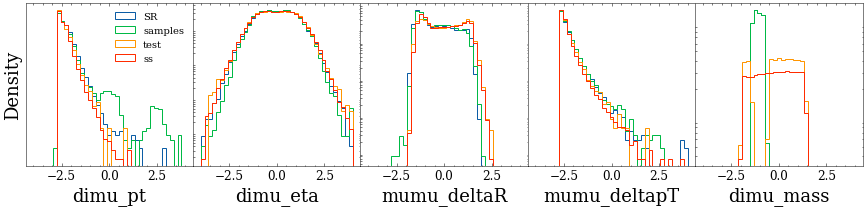

In [5]:
def hist_all_features(samples, labels, feature_set, plot_bound=3, yscale_log=False):
    scaled_feature_bins = [np.linspace(-plot_bound, plot_bound, 40) for i in range(len(feature_set))]   
    
    n_features = len(feature_set)
    fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))
        

    for i, feat in enumerate(feature_set):
        for j, samp in enumerate(samples):
            ax[i].hist(samp[:,i], bins = scaled_feature_bins[i], histtype = "step", density = True, label = labels[j])
         
        if yscale_log:
            ax[i].set_yscale("log")
        ax[i].set_xlabel(feat)
        ax[i].set_yticks([])
    ax[0].legend()
    ax[0].set_ylabel("Density")
    plt.subplots_adjust(wspace=0)
    plt.show()
  

hist_all_features([data_dict["SR"], data_dict["SR_samples"], test_events_SB, test_events_samesign], ["SR", "samples", "test", "ss"], feature_set, plot_bound = 4, yscale_log = True)



## Train the BDTs

Train to discriminate (flow samples in SR) from (test data in SR)

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [7]:
def run_BDT_bump_hunt(flow_samples_SR, data_samples_SR, data_samples_SB, num_folds, num_to_ensemble, 
                      alt_test_sets_data={}):
    
    """
    Classifier is trained only on SR data, to distinguish flow SR samples from SR data
    
    Classifier is evaluated on test data from SR AND SB
    
    Note that alt test sets are NOT split into folds, since we aren't training on them. We do get diff scores for each fold
    """
    
    test_data_splits = {i:0 for i in range(num_folds)}
    scores_splits = {i:0 for i in range(num_folds)}
    
    alt_scores_splits = {}
    for alt_id in alt_test_sets_data.keys():
        alt_scores_splits[alt_id] = {i:0 for i in range(num_folds)}
    
    
    flow_SR_splits = np.array_split(flow_samples_SR, num_folds)
    data_SR_splits = np.array_split(data_samples_SR, num_folds)
    data_SB_splits = np.array_split(data_samples_SB, num_folds)

    for i_fold in range(num_folds):
    
        print(f"Fold {i_fold}:")
        
        # Assemble the train / test data in a hacky way
        training_data = []
        training_labels = []
        testing_data = []
        
        for ii in range(num_folds):
            if ii != i_fold:
                training_data.append(flow_SR_splits[ii])
                training_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                training_data.append(data_SR_splits[ii])
                training_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
            else:
                testing_data.append(data_SR_splits[ii])
                testing_data.append(data_SB_splits[ii])
                
        X_train_fold = np.concatenate(training_data)
        Y_train_fold = np.concatenate(training_labels)
        X_test_fold = np.concatenate(testing_data)
        
        test_data_splits[i_fold] = X_test_fold
 

        print(f"X train shape: {X_train_fold.shape}, Y train shape: {Y_train_fold.shape}. X test shape: {X_test_fold.shape}." )

        # adjust for class weights
        class_weight = {0: 1, 1: sum(Y_train_fold==0)[0]/sum(Y_train_fold==1)[0]}
        class_weights = class_weight[0]*(1.0-Y_train_fold)+class_weight[1]*Y_train_fold

        Y_train_fold = Y_train_fold.reshape(-1,)
        class_weights = class_weights.reshape(-1,)

        print("Training class weights: ", class_weight)

        scores_fold = np.empty((X_test_fold.shape[0], num_to_ensemble))
        alt_scores_fold = {}
        for alt_id in alt_test_sets_data.keys():
            alt_scores_fold[alt_id] = np.empty((alt_test_sets_data[alt_id].shape[0], num_to_ensemble))
            
   
        for i_tree in range(num_to_ensemble):

            print("   Tree number:", i_tree)
            np.random.seed(i_fold*num_to_ensemble + i_tree + 1)

            tree = HistGradientBoostingClassifier(verbose=0, max_iter=200, max_leaf_nodes=50, validation_fraction=0.25, early_stopping=True)
            results_f = tree.fit(X_train_fold[:,:-1], Y_train_fold, sample_weight=class_weights)
            
            # test
            scores_fold[:,i_tree] = tree.predict_proba(X_test_fold[:,:-1])[:,1]
            for alt_id in alt_test_sets_data.keys():
                alt_scores_fold[alt_id][:,i_tree] = tree.predict_proba(alt_test_sets_data[alt_id][:,:-1])[:,1]
            
            del results_f
            
        scores_splits[i_fold] = np.mean(scores_fold, axis = 1)
        for alt_id in alt_test_sets_data.keys():
            alt_scores_splits[alt_id][i_fold] = np.mean(alt_scores_fold[alt_id], axis = 1)
            
        print()


    return test_data_splits, scores_splits, alt_scores_splits




In [8]:
# Train a classifier to discriminate SR samples from SR data

n_folds = 5
n_to_ensemble = 10

test_data_splits, scores_splits, alt_scores_splits = run_BDT_bump_hunt(data_dict["SR_samples"], 
                                        test_events_SR, test_events_SB, n_folds, n_to_ensemble, 
                                            alt_test_sets_data = {"FPR_validation":data_dict["SR_samples_validation"],"samesign":test_events_samesign})




Fold 0:
X train shape: (102980, 5), Y train shape: (102980, 1). X test shape: (6400, 5).
Training class weights:  {0: 1, 1: 13.553420011305823}
   Tree number: 0
   Tree number: 1
   Tree number: 2
   Tree number: 3
   Tree number: 4
   Tree number: 5
   Tree number: 6
   Tree number: 7
   Tree number: 8
   Tree number: 9

Fold 1:
X train shape: (102981, 5), Y train shape: (102981, 1). X test shape: (6400, 5).
Training class weights:  {0: 1, 1: 13.553561334087055}
   Tree number: 0
   Tree number: 1
   Tree number: 2
   Tree number: 3
   Tree number: 4
   Tree number: 5
   Tree number: 6
   Tree number: 7
   Tree number: 8
   Tree number: 9

Fold 2:
X train shape: (102981, 5), Y train shape: (102981, 1). X test shape: (6400, 5).
Training class weights:  {0: 1, 1: 13.553561334087055}
   Tree number: 0
   Tree number: 1
   Tree number: 2
   Tree number: 3
   Tree number: 4
   Tree number: 5
   Tree number: 6
   Tree number: 7
   Tree number: 8
   Tree number: 9

Fold 3:
X train shape: (1

## Analysis

### True bump hunt

- Define a polynomial form for the background fit
- For each cut on the classifier score:
  - Fit the background on the cut SB data
  - Estimate N_bkg
  - Calculate S/B, S/sqrt(B)



In [9]:
with open(f"processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
sorted_masses_splits = {}

fpr_thresholds = [1,  .7, 0.4, 0.1, 0.05, 0.01]
score_cutoffs = {i:[] for i in range(n_folds)}


for i_fold in range(n_folds):
    
    """ 
    # OLD METHOD: SORTING SCORES
    # sort the scores
    loc_sorted_indices = np.argsort(scores_splits[i_fold])
    
    # get the true masses from low to high score
    sorted_masses_splits[i_fold] = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1][loc_sorted_indices]).reshape(-1,1))
   
    
    plt.figure()
    plt.hist(alt_scores_splits["FPR_validation"][i_fold], bins = np.linspace(0, 1, 40), histtype = "step", density = True, label = "FPR")
    plt.hist(scores_splits[i_fold], bins = np.linspace(0, 1, 40), histtype = "step", density = True, label = "test")
    plt.hist(alt_scores_splits["samesign"][i_fold], bins = np.linspace(0, 1, 40), histtype = "step", density = True, label = "ss")
    plt.legend()
    plt.show()
    """
    
    # NEW METHOD: score cutoff from vaidation fpr
    # from EBH paper
    
    for t in fpr_thresholds:
        
        loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold])
        score_cutoff = 1-loc_scores_sorted[min(int(t*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
   
        score_cutoffs[i_fold].append(score_cutoff)  
print(score_cutoffs)

{0: [0.0005932432933146714, 0.3408751103300831, 0.45399255448684417, 0.579054103187378, 0.6344022832844317, 0.7296179791359583], 1: [0.0005090900160811263, 0.3258403634167073, 0.4534578977324262, 0.5790808525306417, 0.6346169994499757, 0.729707157595523], 2: [0.00034608353431142547, 0.33077830217792015, 0.45427705101478, 0.5784106184468824, 0.6329501364941217, 0.7288708479122235], 3: [0.0008953199142623935, 0.3402278700053526, 0.4556202596023745, 0.574039014348384, 0.6284193171615007, 0.7249501239958571], 4: [0.00033259343755176474, 0.32979843598930714, 0.45235831037403973, 0.5766163023053543, 0.6322295288789905, 0.7339108929556963]}


chi2/dof: 0.7110130819948797
chi2/dof: 1.2485551131904564
chi2/dof: 9.523419363508093
chi2/dof: 17.589104879808538
chi2/dof: 22.389033948879742
chi2/dof: 21.77763423211065


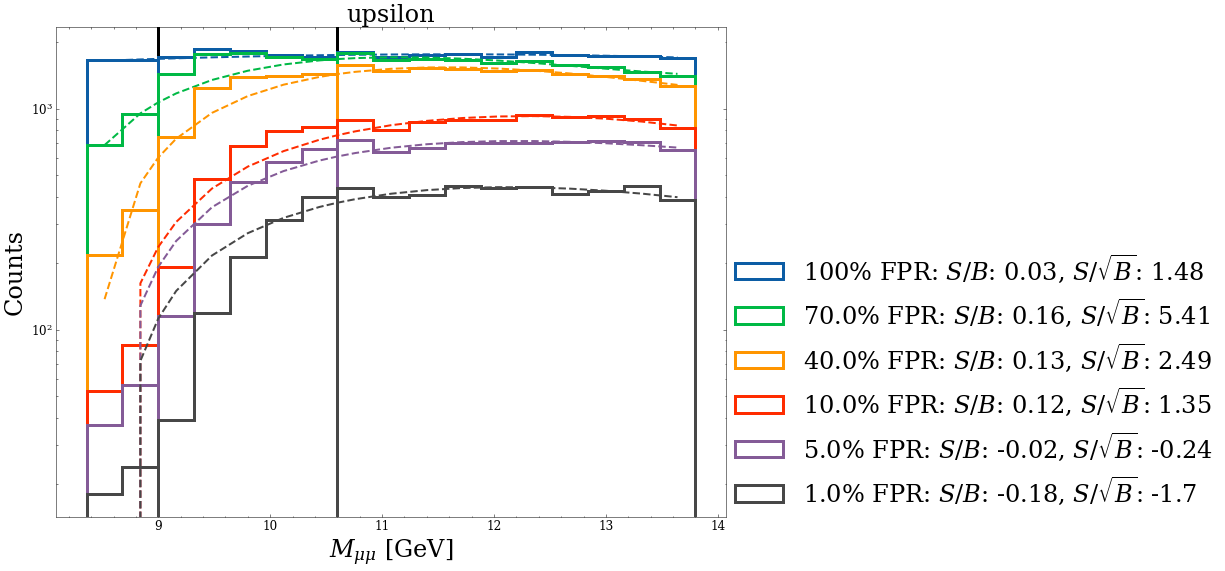

In [10]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    
    
plot_bins_SR = np.linspace(SR_left, SR_right, 6)
x_SR_center = 0.5*(plot_bins_SR[1:] + plot_bins_SR[:-1])
width = plot_bins_SR[1] - plot_bins_SR[0]
x = np.linspace(SB_left, SB_right, 100)


remove_edge = True



fit_type = "cubic"

if fit_type == "cubic":
    p0  = [5000, -20000, 30000, -10000]
    bkg_fit_function = bkg_fit_cubic
    n_dof_fit = 4
    
elif fit_type == "quintic":
    p0  = [5000, -20000, 30000, -10000, 0, 0]
    bkg_fit_function = bkg_fit_quintic
    n_dof_fit = 6
    
elif fit_type == "ratio":
    p0  = [1000,1000,0.1]
    bkg_fit_function = bkg_fit_ratio
    n_dof_fit = 3


plt.figure(figsize = (12, 9))
#for p, percent in enumerate([100, 80, 60, 40, 20]):
for p, threshold in enumerate(fpr_thresholds):
    
        
    filtered_masses = []
    
    for i_fold in range(n_folds):
        """
        # grab the top percent of events FROM EACH FOLD
        loc_num_events_to_take = int(percent*sorted_masses_splits[i_fold].shape[0]/100)
        filtered_masses.append(np.array(sorted_masses_splits[i_fold][-loc_num_events_to_take:]).reshape(-1,1))
        """
        
        # get the true masses
        loc_true_masses = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1]).reshape(-1,1))
        # get the events that pass the score threshold
        pass_scores = scores_splits[i_fold] >= score_cutoffs[i_fold][p]
        filtered_masses.append(loc_true_masses[pass_scores])
        

    filtered_masses = np.concatenate(filtered_masses)
    
    
    popt, pcov, chi2, dof_data, plot_bins_left, plot_bins_right = curve_fit_m_inv(filtered_masses, bkg_fit_function, SB_left, SB_right, SR_left, SR_right, width, p0, remove_edge = True)
    #print(popt)
    
    plot_bins = np.concatenate([plot_bins_left, plot_bins_SR, plot_bins_right])
    plot_centers = 0.5*(plot_bins[1:] + plot_bins[:-1])

    n_dof = dof_data - n_dof_fit
    print("chi2/dof:", chi2/n_dof)
    
    plt.plot(plot_centers, bkg_fit_function(plot_centers, *popt), lw = 2, linestyle = "dashed", color = f"C{p}")
    #plt.scatter(plot_centers, bkg_fit_function(plot_centers, *popt),color = f"C{p}")
    
    
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, bkg_fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, x_SR_center, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins, lw = 3, histtype = "step", color = f"C{p}",label = label_string)
    
    
    
    
#plt.title(",  ".join(feature_set[:-1])+"\n", fontsize = 18) 
plt.legend(loc = (1, 0), fontsize = 24)
plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(particle_type, fontsize = 24)
plt.show()

Repeat for samesign background

chi2/dof: 13.052864062656163
chi2/dof: 16.136858468921055
chi2/dof: 380.56967203067313
chi2/dof: 825.5804697334183
chi2/dof: 876.8430491717859
chi2/dof: 972.8585094214715


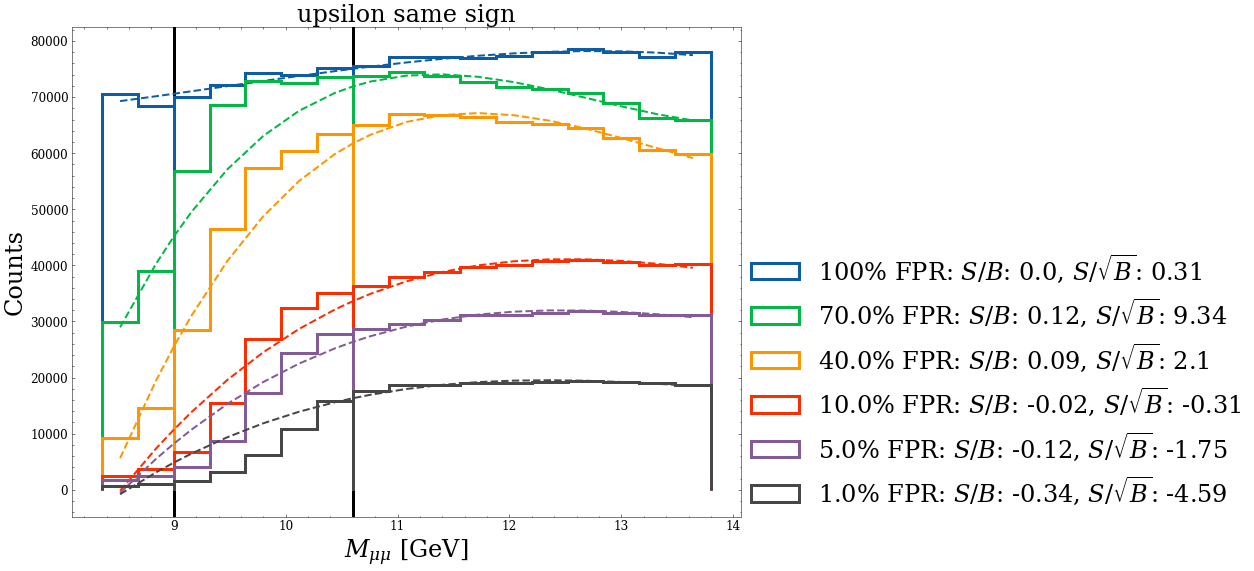

In [11]:
fit_type = "cubic"

if fit_type == "cubic":
    p0  = [5000, -20000, 30000, -10000]
    bkg_fit_function = bkg_fit_cubic
    n_dof_fit = 4
    
elif fit_type == "quintic":
    p0  = [5000, -20000, 30000, -10000, 0, 0]
    bkg_fit_function = bkg_fit_quintic
    n_dof_fit = 6
    
elif fit_type == "ratio":
    p0  = [1000,1000,0.1]
    bkg_fit_function = bkg_fit_ratio
    n_dof_fit = 3


plt.figure(figsize = (12, 9))
#for p, percent in enumerate([100, 80, 60, 40, 20]):
for p, threshold in enumerate(fpr_thresholds):
        
    filtered_masses = []
    
    for i_fold in range(n_folds):
        """
        loc_sorted_indices = np.argsort(alt_scores_splits["samesign"][i_fold])
        loc_sorted_masses = scaler.inverse_transform(np.array(test_events_samesign[:,-1][loc_sorted_indices]).reshape(-1,1))

        
        # grab the top percent of events FROM EACH FOLD
        loc_num_events_to_take = int(percent*loc_sorted_masses.shape[0]/100)
        filtered_masses.append(np.array(loc_sorted_masses[-loc_num_events_to_take:]).reshape(-1,1))
        """
        
        # get the true masses
        loc_true_masses = scaler.inverse_transform(test_events_samesign[:,-1].reshape(-1,1))
        # get the events that pass the score threshold
        pass_scores = alt_scores_splits["samesign"][i_fold] >= score_cutoffs[i_fold][p]
        filtered_masses.append(loc_true_masses[pass_scores])
        
        
    filtered_masses = np.concatenate(filtered_masses)
    
    popt, pcov, chi2, dof_data, plot_bins_left, plot_bins_right = curve_fit_m_inv(filtered_masses, bkg_fit_function, SB_left, SB_right, SR_left, SR_right, width, p0, remove_edge = True)
    #print(popt)
    
    plot_bins = np.concatenate([plot_bins_left, plot_bins_SR, plot_bins_right])
    plot_centers = 0.5*(plot_bins[1:] + plot_bins[:-1])

    n_dof = dof_data - n_dof_fit
    print("chi2/dof:", chi2/n_dof)
    
    plt.plot(plot_centers, bkg_fit_function(plot_centers, *popt), lw = 2, linestyle = "dashed", color = f"C{p}")
    #plt.scatter(plot_centers, bkg_fit_function(plot_centers, *popt),color = f"C{p}")
    
    
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, bkg_fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, x_SR_center, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins, lw = 3, histtype = "step", color = f"C{p}",label = label_string)
    
    
    
    
    
#plt.title(",  ".join(feature_set[:-1])+"\n", fontsize = 18) 
plt.legend(loc = (1, 0), fontsize = 24)
#plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type} same sign", fontsize = 24)

plt.show()